In [1]:
import csv

import requests
import numpy as np

import itkConfig
itkConfig.LazyLoading = False

import itk
import vtk
from itkwidgets import view
import icon_registration.itk_wrapper as itk_wrapper
import icon_registration.pretrained_models as pretrained_models
import matplotlib.pyplot as plt

import sys
sys.path.append("/data/OAI_analysis_2/oai_analysis_2")

import mesh_processing as mp

#import os
#os.environ["CUDA_VISIBLE_DEVICES"]=""

from dask import delayed, compute, visualize
from dask.distributed import Client, progress
from skimage import measure

In [2]:


# import pickle

# def pickle_dumps(x):
#     header = {'serializer': 'pickle'}
#     frames = [pickle.dumps(x)]
#     return header, frames

# def pickle_loads(header, frames):
#     if len(frames) > 1:  # this may be cut up for network reasons
#         frame = ''.join(frames)
#     else:
#         frame = frames[0]
#     return pickle.loads(frame)

# from distributed.protocol.serialize import register_serialization_family
# register_serialization_family('pickle', pickle_dumps, pickle_loads)


client = Client(n_workers=1, 
                serializers=['pickle', 'dask',],
                deserializers=['pickle', 'dask'])
client

2022-04-16 15:40:48,354 - distributed.diskutils - INFO - Found stale lock file and directory '/home/pranjal.sahu/OAI/OAI_analysis/dask-worker-space/worker-cjux_ypd', purging


Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:8787/status,
Dashboard: http://127.0.0.1:8787/status,Workers: 1
Total threads: 16,Total memory: 125.73 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:40465,Workers: 1
Dashboard: http://127.0.0.1:8787/status,Total threads: 16
Started: Just now,Total memory: 125.73 GiB
Comm: tcp://127.0.0.1:35283,Total threads: 16
Dashboard: http://127.0.0.1:43243/status,Memory: 125.73 GiB
Nanny: tcp://127.0.0.1:45111,


In [47]:
# All Function Definitions

def download_data():
    os.system('girder-client --api-url https://data.kitware.com/api/v1 localsync 621a5d784acac99f426c143b OAIData')
    
    get_dagster_logger().info('Data download done')

    image_preprocessed = "./OAIData/atlas_image.nii.gz"
    atlas_image = "./OAIData/atlas_image.nii.gz"
    return image_preprocessed, atlas_image

@delayed(nout=2)
def read_images(image_preprocessed, atlas_image):
    image_A = itk.imread(image_preprocessed, itk.D)
    image_B = itk.imread(atlas_image, itk.D)
    return image_A, image_B

def register_images(image_A, image_B):
    model = pretrained_models.OAI_knees_registration_model()
    #model.to('cpu')

    # Register the images
    phi_AB, phi_BA = itk_wrapper.register_pair(model, image_A, image_B)
    
    return phi_AB

def deform_probmap(phi_AB, image_A, image_B):
    fc_prob_file = '/data/OAI_analysis_2/OAIData/FC_probmap.nii.gz'
    tc_prob_file = '/data/OAI_analysis_2/OAIData/TC_probmap.nii.gz'

    FC_prob = itk.imread(fc_prob_file)
    TC_prob = itk.imread(tc_prob_file)

    interpolator = itk.LinearInterpolateImageFunction.New(image_A)
    warped_image_FC = itk.resample_image_filter(FC_prob, 
        transform=phi_AB, 
        interpolator=interpolator,
        size=itk.size(image_B),
        output_spacing=itk.spacing(image_B),
        output_direction=image_B.GetDirection(),
        output_origin=image_B.GetOrigin()
    )

    warped_image_TC = itk.resample_image_filter(TC_prob, 
        transform=phi_AB, 
        interpolator=interpolator,
        size=itk.size(image_B),
        output_spacing=itk.spacing(image_B),
        output_direction=image_B.GetDirection(),
        output_origin=image_B.GetOrigin()
    )
    
    return warped_image_FC, warped_image_TC

@delayed
def deform_probmap_FC(phi_AB, image_A, image_B):
    fc_prob_file = '/data/OAI_analysis_2/OAIData/FC_probmap.nii.gz'

    FC_prob = itk.imread(fc_prob_file)

    interpolator = itk.LinearInterpolateImageFunction.New(image_A)
    warped_image_FC = itk.resample_image_filter(FC_prob, 
        transform=phi_AB, 
        interpolator=interpolator,
        size=itk.size(image_B),
        output_spacing=itk.spacing(image_B),
        output_direction=image_B.GetDirection(),
        output_origin=image_B.GetOrigin()
    )

    return warped_image_FC

@delayed
def deform_probmap_TC(phi_AB, image_A, image_B):
    tc_prob_file = '/data/OAI_analysis_2/OAIData/TC_probmap.nii.gz'

    TC_prob = itk.imread(tc_prob_file)

    interpolator = itk.LinearInterpolateImageFunction.New(image_B)
    warped_image_TC = itk.resample_image_filter(TC_prob, 
        transform=phi_AB, 
        interpolator=interpolator,
        size=itk.size(image_B),
        output_spacing=itk.spacing(image_B),
        output_direction=image_B.GetDirection(),
        output_origin=image_B.GetOrigin()
    )

    return warped_image_TC

#@delayed
def get_faces(itk_image):
    spacing = itk_image.GetSpacing()
    itk_image_array = np.asarray(itk_image)
    img_array = np.swapaxes(itk_image_array, 0, 2).astype(float)
    
    from skimage import measure
    # Obtain the mesh from Probability maps using Marching Cubes
    verts, faces, normals, values = measure.marching_cubes_lewiner(img_array, 0.5,
                                                                    spacing=spacing,
                                                                    step_size=1, 
                                                                    gradient_direction="ascent")
    
    mesh = mp.get_vtk_mesh(verts, faces)

    # For smoothing the mesh surface to obtain gradually varying face normals
    mesh = mp.smooth_mesh(mesh, num_iterations=150)
    
    itk_mesh = get_itk_mesh(mesh)
    
    return itk_mesh
    
def get_itk_mesh(vtk_mesh):
    Dimension = 3
    PixelType = itk.D
    
    MeshType = itk.Mesh[PixelType, Dimension]
    itk_mesh = MeshType.New()
    
    # Get points array from VTK mesh
    points = vtk_mesh.GetPoints().GetData()
    points_numpy = np.array(points).flatten().astype('float32')
        
    polys = vtk_mesh.GetPolys().GetData()
    polys_numpy = np.array(polys).flatten()

    # Triangle Mesh
    vtk_cells_count = vtk_mesh.GetNumberOfPolys()
    polys_numpy = np.reshape(polys_numpy, [vtk_cells_count, Dimension+1])

    # Extracting only the points by removing first column that denotes the VTK cell type
    polys_numpy = polys_numpy[:, 1:]
    polys_numpy = polys_numpy.flatten().astype(np.uint64)

    # Get point data from VTK mesh to insert in ITK Mesh
    point_data_numpy = np.array(vtk_mesh.GetPointData().GetScalars())#.astype('float64')
    
    # Get cell data from VTK mesh to insert in ITK Mesh
    cell_data_numpy = np.array(vtk_mesh.GetCellData().GetScalars())#.astype('float64')
    
    itk_mesh.SetPoints(itk.vector_container_from_array(points_numpy))
    itk_mesh.SetCellsArray(itk.vector_container_from_array(polys_numpy), itk.CommonEnums.CellGeometry_TRIANGLE_CELL)
    itk_mesh.SetPointData(itk.vector_container_from_array(point_data_numpy))
    itk_mesh.SetCellData(itk.vector_container_from_array(cell_data_numpy))    
    return itk_mesh

    
@delayed
def get_thickness_FC(warped_image_FC):
    distance_inner_FC, distance_outer_FC = mp.get_thickness_mesh(warped_image_FC, mesh_type='FC')
    distance_inner_FC = get_itk_mesh(distance_inner_FC)
    return distance_inner_FC

@delayed
def get_thickness_TC(warped_image_TC):
    distance_inner_TC, distance_outer_TC = mp.get_thickness_mesh(warped_image_TC, mesh_type='TC')
    distance_inner_TC = get_itk_mesh(distance_inner_TC)
    return distance_inner_TC

@delayed(nout=2)
def get_paths():
    image_preprocessed = "/data/OAI_analysis_2/OAIData/image_preprocessed.nii.gz"
    atlas_image = "/data/OAI_analysis_2/OAIData/atlas_image.nii.gz"

    return image_preprocessed, atlas_image

@delayed(nout=2)
def register_and_deform(image_A, image_B):
    phi_AB                               = register_images(image_A=image_A, image_B=image_B)
    warped_image_FC, warped_image_TC     = deform_probmap(phi_AB=phi_AB, image_A=image_A, image_B=image_B)
    return warped_image_FC, warped_image_TC

@delayed
def only_register_image(image_A, image_B):
    phi_AB  = register_images(image_A=image_A, image_B=image_B)
    return phi_AB

#@delayed
def entire_job(warped_image_FC, warped_image_TC):
    distance_inner_FC, distance_inner_TC = get_thickness(warped_image_FC=warped_image_FC, warped_image_TC=warped_image_TC)

    writer1 = vtk.vtkPolyDataWriter()
    writer1.SetFileName('distance_inner_FC.vtk')
    writer1.SetInputData(distance_inner_FC)
    writer1.Update()

    writer2 = vtk.vtkPolyDataWriter()
    writer2.SetFileName('distance_inner_TC.vtk')
    writer2.SetInputData(distance_inner_TC)
    writer2.Update()

#@delayed
def thickness_compute():
    #image_preprocessed, atlas_image = download_data()
    #image_preprocessed = "./OAIData/atlas_image.nii.gz"
    #atlas_image = "./OAIData/atlas_image.nii.gz"

    #image_preprocessed, atlas_image =  get_paths()
    
    # In ITKrc4 images, mesh and transform can be serialized
    image_preprocessed, atlas_image   = get_paths()
    image_A, image_B                  = read_images(image_preprocessed, atlas_image)
    warped_image_FC, warped_image_TC  = register_and_deform(image_A, image_B)
    
    distance_inner_FC, distance_outer_FC = mp.get_thickness_mesh(warped_image_FC, mesh_type='FC')
    distance_inner_TC, distance_outer_TC = mp.get_thickness_mesh(warped_image_TC, mesh_type='TC')
    
    return distance_inner_FC, distance_inner_TC

In [48]:
result = []

image_preprocessed, atlas_image   = get_paths()

image_A, image_B  = read_images(image_preprocessed, atlas_image)
phi_AB            = only_register_image(image_A, image_B)

warped_image_FC = deform_probmap_FC(phi_AB, image_A, image_B)
warped_image_TC = deform_probmap_TC(phi_AB, image_A, image_B)

thickness_FC = get_thickness_FC(warped_image_FC)
thickness_TC = get_thickness_TC(warped_image_TC)

result.append(thickness_FC)
result.append(thickness_TC)

#test_mesh = get_faces(warped_image_FC)
#phi_AB                               = register_images(image_A=image_A, image_B=image_B)

# distance_inner_FC, distance_outer_FC = get_thickness_dask(warped_image_FC, mesh_type='FC')
# distance_inner_TC, distance_outer_TC = get_thickness_dask(warped_image_TC, mesh_type='TC')

# all_distance = [distance_inner_FC, distance_inner_TC]

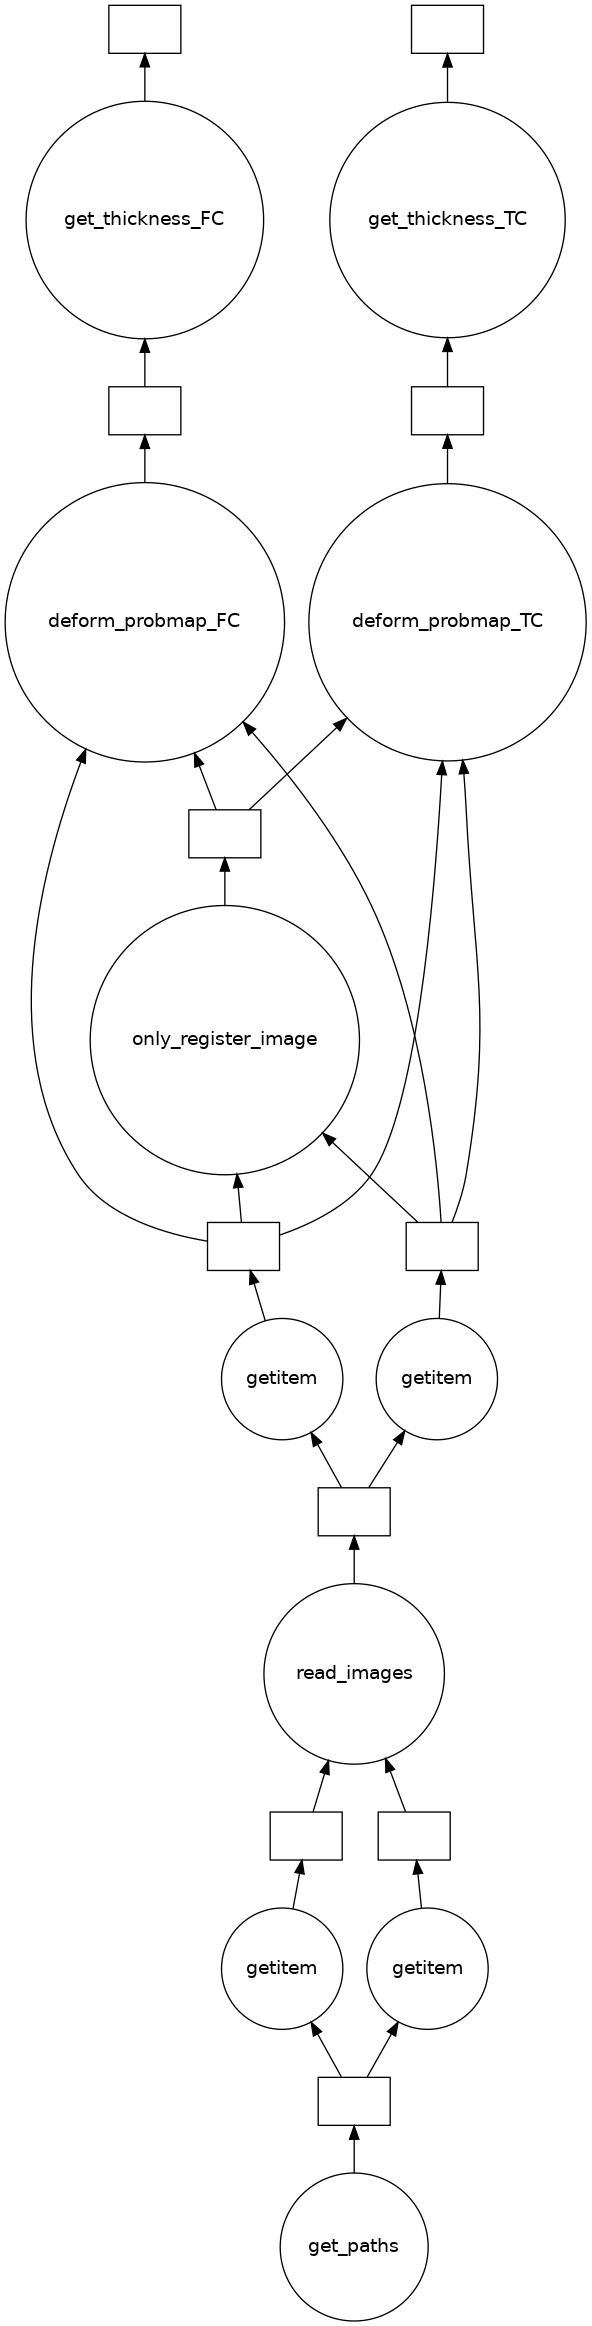

In [49]:
visualize(*result)

**Note:** Try to minimize computing.

In [40]:
%%time

l = compute(*result)

CPU times: user 469 ms, sys: 32.3 ms, total: 502 ms
Wall time: 15.4 s


In [41]:
distance_inner_FC = l[0]
distance_inner_TC = l[1]

itk.meshwrite(distance_inner_FC, 'itk_distance_inner_FC.vtk')
itk.meshwrite(distance_inner_TC, 'itk_distance_inner_TC.vtk')

In [26]:
import itkwidgets
import vtk

a1 = vtk.vtkPolyDataReader()
a1.SetFileName('itk_distance_inner_FC.vtk')
a1.Update()
distance_inner_FC = a1.GetOutput()

itkwidgets.view(geometries=[distance_inner_FC])
#itkwidgets.view(warped_image_FC)

Viewer(geometries=[{'vtkClass': 'vtkPolyData', 'points': {'vtkClass': 'vtkPoints', 'name': '_points', 'numberO…